# 학습 관련된 기술들

### 다룰 주제: 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 -> 다 중요한 것들

### SGD 복습

W <- W - $\eta{\operatorname{d}\!L\over\operatorname{d}\!W}$

여기서 $\eta$(에타)는 학습률로 0.01이나 0.001임

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr#learning rate
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -=self.lr*grads[key]

### SGD의 단점

SGD는 단순하고 구현도 쉽지만, 때에 따라 비효율적일 때가 있음.

비등방성함수에는 탐색 경로가 지그재그여서 비효율적임.

### 모멘텀

모멘텀은 '운동량'을 뜻하는 단어로 물리와 관계가 있음.

W <- W + v 여기서 v는 velocity

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### Adagrad

신경망에서는 학습률이 작으면 학습시간이 길어지고 너무 크면 발산하여 학습이 제대로 이뤄지지 않아서  
학습률이 중요한데 전체적인 학습률 값을 낮추는 것을 발전시킨 버전이 Adagrad

$ h \longleftarrow h+{\partial L\over\partial W}\bigodot{\partial L \over\partial W} $

$ W \longleftarrow W - \eta{1\over\sqrt{h}}{\partial L\over \partial W}$

h는 기존 기울기 값을 제곱하여 계속 더해주고  
매개변수 갱신할 때는 1/루트h를 곱해 학습률을 조정함.  
매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻 -> 학습률 감소가 매개변수의 원소마다 적용됨을 뜻함

AdaGrad는 과거의 기울기를 제곱하여 계속 더하다보니 진행할수록  
갱신강도가 약해져 계속 학습하다보면 어느 순간 갱신량이 0이 됨  
이것을 개선한 기법이 RMSProp임.  
RMSProp은 과거의 모든 기울기를 균일하게 더하지 않고 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영함.  
* 이를 지수이동평균(Exponential Moving Average EMA)라 한다.

In [4]:
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr*grads[key]/(np.sqrt(self.h[key])+1e-7)#여기서 1e-7이 0으로 나누는 사태를 막아줌

Adagrad는 u축 방향이 기울기가 커서 크게 움직이지만 큰 움직임에  
비례하여 갱신 정도도 큰 폭으로 작아지도록 조정됨.  
따라서 y축 방향으로 갱신 강도가 빠르게 약해지고 지그재그 움직임이 줄어듬

### Adam

모멘텀과 Adagrad를 합친 것.

## 그래서 어느 갱신 방법을 이용할텨?

-> 문제마다 다름  
내가 배우는 책에서는 SGD와 Adam 주로 사용

## 가중치의 초깃값

신경망 학습에서 특히 중요한 것이 가중치의 초깃값.

### if 초깃값 0

오버피팅을 억제하기 위해 가중치 감소라는 기법을 사용한다.  
하지만 가중치의 초깃값을 0으로 설정하면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문에 안됨

### 은닉층의 활성화값 분포

은닉층의 활성화값(호라성화 함수의 출력 데이터)의 분포를 관찰하면 좋은 정보를 얻을 수 있음

밑은 CS231n 수업에 나온 내용으로 활서오하 함수로 시그모이드 함수를 사용하는 5층  
신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활서오하값 분포를 히스토그램으로 그리는 코드  

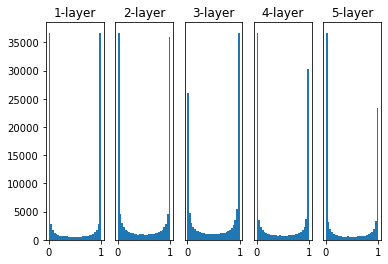

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0과 1에 분포가 치우쳐 있는 것이 기울기 소실임

In [6]:
# w = np.random.randn(node_num, node_num)*1
w = np.random.randn(node_num, node_num)*0.01

다수의 뉴런이 거의 같은 출력하고 있으니 뉴런을 여러 개 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻.  
-> 100개의 뉴런이 거의 같은 값을 출력  
-> 표현력 제한